In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
from skimage import transform
from PIL import Image
import scipy
import random
# from scipy import misc
import scipy.ndimage
from scipy.signal import medfilt2d
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

In [3]:
def normlize_function(point):
    # Center the image data at the origin
    mean = np.mean(point, axis =0)
    
    # scale
#     max_x = max(abs(point[:, 0]))
#     max_y = max(abs(point[:, 1]))
    square_pts = np.square(point)
    scale = np.sqrt(np.sum(square_pts)/(2*point.shape[0]))
    
    # Compute T
#     transform = np.array([[1/max_x, 0, - mean[0]/max_x],
#                           [0, 1/max_y, - mean[1]/max_y],
#                             [0, 0, 1]])
    transform = np.array([[1/scale, 0, - mean[0]/scale],
                          [0, 1/scale, - mean[1]/scale],
                            [0, 0, 1]])
    
    # normlized coord
    points = np.hstack((point, np.ones((point.shape[0], 1))))
    normalized = np.dot(transform, points.T).T
    return normalized[:, 0:2], transform
    
def fit_fundamental(matches, normalized = False, option = 'homo'):
    
    # Extract matches
    matches1 = matches[:, 0:2]
    matches2 = matches[:, 2:4]
    
    if (normalized == True):
        # Normalized data
        matches1, T1 = normlize_function(matches1)
        matches2, T2 = normlize_function(matches2)
        
#     index = random.sample(range(matches.shape[0]), 15)
    pts1 = matches1
    pts2 = matches2
    
    # Fundamental matrix estimation
    
    temp_A = []
    
    for i in range(pts1.shape[0]):
        p1 = pts1[i]
        p2 = pts2[i]
        
        row = [p2[0]*p1[0], p2[0]*p1[1], p2[0],
               p2[1]*p1[0], p2[1]*p1[1], p2[1],
               p1[0], p1[1], 1]
        
        temp_A.append(row)
        
    A = np.array(temp_A)
    
    if option == 'homo':
        u, s, v = np.linalg.svd(A)
        F = v[len(v) - 1].reshape(3,3)
        F = F / F[2,2]
        
    elif option == 'no_homo':
        A = A[:, 0:8]
#         print(type(np.ones((A.shape[1]))*-1).shape)
#         F = np.linalg.solve(A, np.ones((A.shape[1]))*-1)
#         F = np.append(F, 1).reshape(3,3)
        invA = np.linalg.pinv(A)

        temp_one = np.ones((A.shape[0],1))*-1

        F = np.dot(invA, temp_one)
        F = np.append(F, 1).reshape(3,3)


        
    # Enforce rank-2 constraint
    
    u, s, v = np.linalg.svd(F)
    new_s = np.diag(s)
#     print(new_s)
    new_s[-1] = 0
#     print(new_s)
    F = np.dot(u, np.dot(new_s, v))
    
    if normalized == True:
        F = np.dot(np.dot(T2.T, F), T1)
    
    return F

In [4]:
def plot (I1, I2, matches, F):
    N = len(matches)
    ##
    ## display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    ##

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1
    I3[:,I1.size[0]:,:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow((np.array(I3)/255).astype(float))
#     ax.imshow((np.array(I3)*255).astype(np.uint8))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
# F = fit_fundamental(matches, normalized = True, option='homo') # this is a function that you should write
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from
#     print('ssss')
#     print(L1[:,0].shape)
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow((np.array(I2)/255).astype(float))
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    plt.show()


In [7]:
def report(matches, F):
    x1 = np.zeros((matches.shape[0],3)) # n x 3
    x2 = np.zeros((matches.shape[0],3)) # n x 3
    for i in range(matches.shape[0]):
        x1[i] = np.array([matches[i,0], matches[i,1], 1])
        x2[i] = np.array([matches[i,2], matches[i,3], 1])
    # Epipolar lines
    
    line1 = np.dot(F, x1.T).T # n x 3 [a,b,c]
    line2 = np.dot(F.T, x2.T).T # n x 3
    
    # Distance
    # sum of Numerator
    numerator1 = np.sum((x1 * line2), axis=1).reshape(matches.shape[0],-1)
    numerator2 = np.sum((x2 * line1), axis=1).reshape(matches.shape[0],-1)
    denomi1 = (np.linalg.norm(line2[:, 0:2], axis=1).reshape(matches.shape[0], -1))
    denomi2 = (np.linalg.norm(line1[:, 0:2], axis=1).reshape(matches.shape[0], -1))
    
    temp_d1 = (abs(numerator1) / denomi1)**2
    temp_d2 = (abs(numerator2) / denomi2)**2

#     Final distance.
    d1 = sum(temp_d1) / matches.shape[0]
    d2 = sum(temp_d2) / matches.shape[0]
    
    return d1, d2

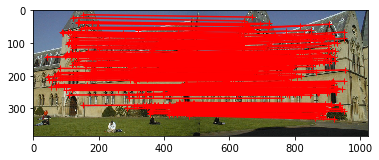

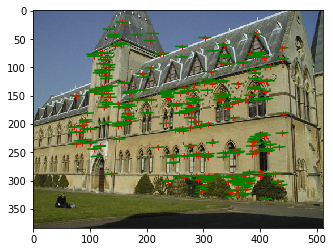

Non-norm and homo distance1 [0.1491231] and distcne2 [0.17921337]:


In [8]:
##
## load images and match files for the first example
##
    
I1 = Image.open('MP3_part2_data/library1.jpg')
I2 = Image.open('MP3_part2_data/library2.jpg')
matches = np.loadtxt('MP3_part2_data/library_matches.txt')

F = fit_fundamental(matches, normalized = False, option = 'homo')
# print(type(F))
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Non-norm and homo distance1 %s and distcne2 %s:' %(dist1, dist2))

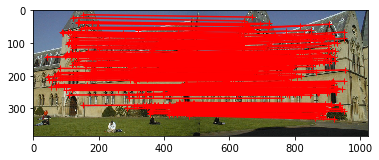

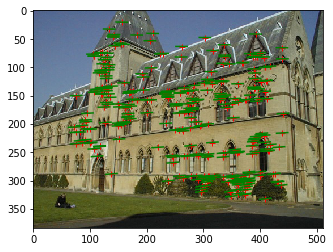

Non-norm and no-homo distance1 [0.14912434] and distcne2 [0.17921562]:


In [9]:
F = fit_fundamental(matches, normalized = False, option = 'no_homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Non-norm and no-homo distance1 %s and distcne2 %s:' %(dist1, dist2))


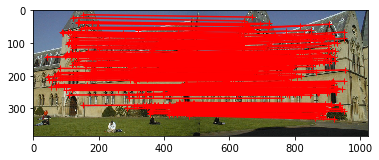

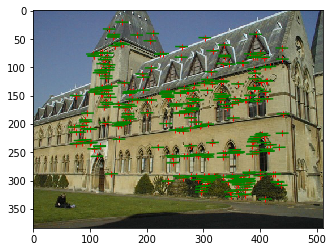

norm and homo distance1 [0.05497127] and distcne2 [0.06077737]:


In [67]:
F = fit_fundamental(matches, normalized = True, option = 'homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('norm and homo distance1 %s and distcne2 %s:' %(dist1, dist2))

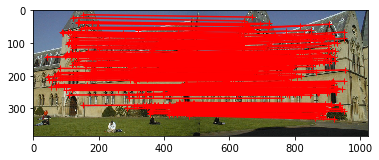

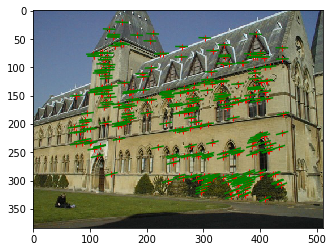

norm and non-homo distance1 [0.11656163] and distcne2 [0.12994752]:


In [68]:
F = fit_fundamental(matches, normalized = True, option = 'no_homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('norm and non-homo distance1 %s and distcne2 %s:' %(dist1, dist2))

<IPython.core.display.Javascript object>


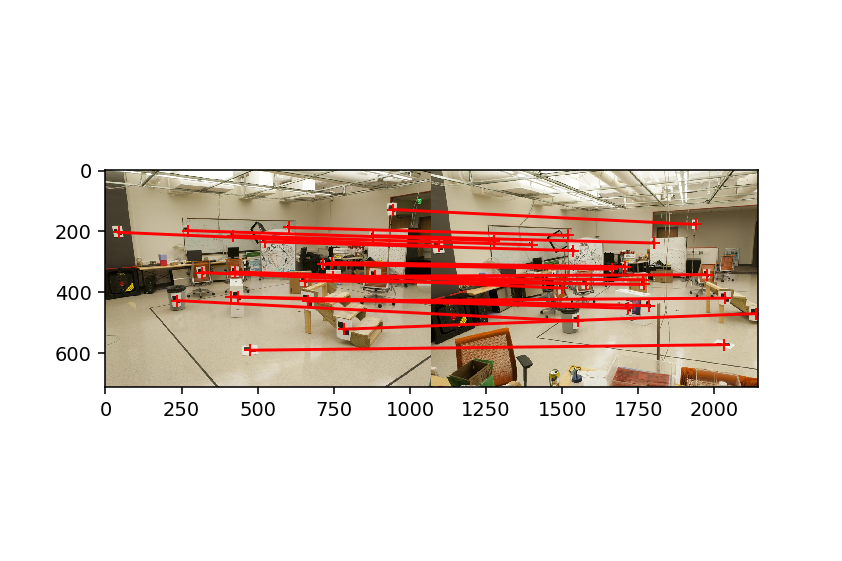

<IPython.core.display.Javascript object>


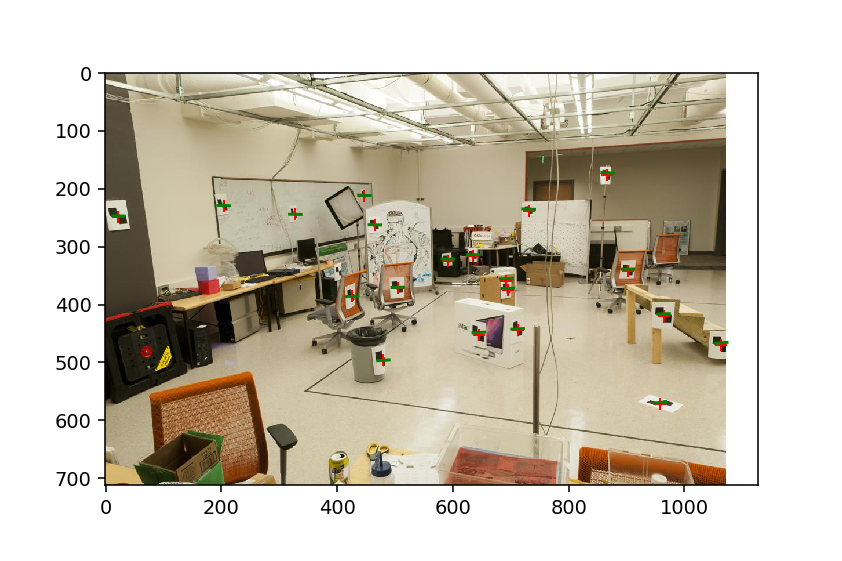

Non-norm and homo distance1 [9.76065542] and distcne2 [6.5670915]:


In [82]:
# Second example
I1 = Image.open('MP3_part2_data/lab1.jpg')
I2 = Image.open('MP3_part2_data/lab2.jpg')
matches = np.loadtxt('MP3_part2_data/lab_matches.txt')

F = fit_fundamental(matches, normalized = False, option = 'homo')
# print(type(F))
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Non-norm and homo distance1 %s and distcne2 %s:' %(dist1, dist2))

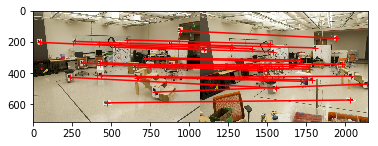

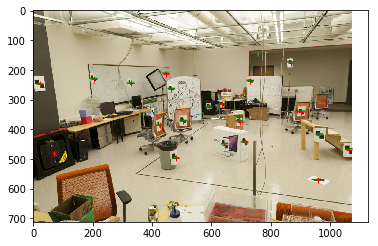

Non-norm and non-homo distance1 [9.81430804] and distcne2 [6.60170276]:


In [70]:
F = fit_fundamental(matches, normalized = False, option = 'no_homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Non-norm and non-homo distance1 %s and distcne2 %s:' %(dist1, dist2))

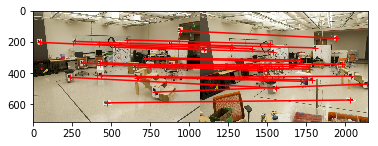

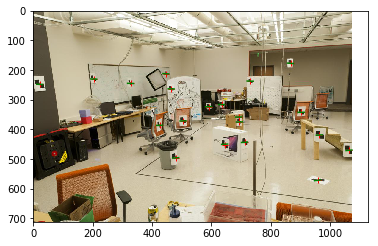

Norm and homo distance1 [0.56707678] and distcne2 [0.52750546]:


In [71]:
F = fit_fundamental(matches, normalized = True, option = 'homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Norm and homo distance1 %s and distcne2 %s:' %(dist1, dist2))

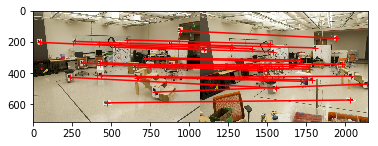

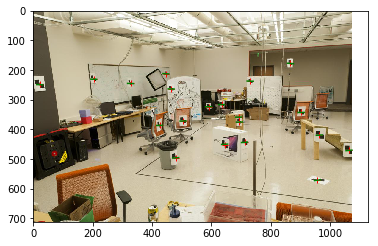

Norm and no-homo distance1 [0.90033358] and distcne2 [0.81499117]:


In [72]:
F = fit_fundamental(matches, normalized = True, option = 'no_homo')
plot(I1, I2, matches, F)
dist1, dist2 = report(matches, F)
print('Norm and no-homo distance1 %s and distcne2 %s:' %(dist1, dist2))

In [73]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [83]:
# # lab pair 
# I1 = Image.open('MP3_part2_data/lab1.jpg')
# I2 = Image.open('MP3_part2_data/lab2.jpg')
# matches = np.loadtxt('MP3_part2_data/lab_matches.txt')
# F = fit_fundamental(matches, normalized = False, option = 'homo')
# plot(I1, I2, matches, F)
# dist1, dist2 = report(matches, F)
# print('Non-norm and homo distance1 %s and distcne2 %s:' %(dist1, dist2))

lab_2Dmatch = np.loadtxt('MP3_part2_data/lab_matches.txt')
lab_3Dpt = np.loadtxt('MP3_part2_data/lab_3d.txt')


In [75]:
# Calibration to figure out the projection matrix
def projection_matrix(pts_2d, pts_3d):
    num_pts = pts_3d.shape[0]
    A = np.zeros((2*num_pts, 12))
    n = 0
    for i in range(num_pts):
        X = pts_3d[i, 0]
        Y = pts_3d[i, 1]
        Z = pts_3d[i, 2]
        x = pts_2d[i, 0]
        y = pts_2d[i, 1]
        
        row1 = np.array([0 ,0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y ])
        row2 = np.array([X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x ])
        
        A[n,:] = row1
        A[n+1, :]= row2
        n =n+2    
    
    u,s,v = np.linalg.svd(np.dot(A.T, A))
    V = v[len(v)-1].reshape((12,-1))
    M = V.reshape((3,4))

    return M

In [76]:
lab_M1 = projection_matrix(lab_2Dmatch[:, 0:2], lab_3Dpt)
print(lab_M1)

# Evaluation
lab1_3D, res1 = evaluate_points(lab_M1, lab_2Dmatch[:, 0:2], lab_3Dpt)

print(res1)

lab_M2 = projection_matrix(lab_2Dmatch[:, 2:4], lab_3Dpt)
print(lab_M2)

# Evaluation
lab2_3D, res2 = evaluate_points(lab_M2, lab_2Dmatch[:, 2:4], lab_3Dpt)
print(res2)

[[-3.09963993e-03 -1.46204682e-04  4.48498020e-04  9.78930694e-01]
 [-3.07018100e-04 -6.37193577e-04  2.77356184e-03  2.04144330e-01]
 [-1.67933509e-06 -2.74767702e-06  6.83965401e-07  1.32882924e-03]]
13.545776180285374
[[-6.93154123e-03  4.01683831e-03  1.32603459e-03  8.26700664e-01]
 [-1.54768613e-03 -1.02452781e-03  7.27440289e-03  5.62523094e-01]
 [-7.60945426e-06 -3.70954047e-06  1.90203848e-06  3.38807524e-03]]
15.5449069211823


In [77]:
# Calculate the camera centers
def camera_center(M):
    center = scipy.linalg.null_space(M)
    center = center/center[-1]
    return center

lab_center1 = camera_center(lab_M1)
lab_center2 = camera_center(lab_M2)

In [78]:
def tranigulation(P1, P2, matches):
    
    num_pts = matches.shape[0]
    x1 = np.hstack((matches[:, 0:2], np.ones((matches.shape[0],1))))
    x2 = np.hstack((matches[:, 2:4], np.ones((matches.shape[0], 1))))
    
    # reconstruction
    coord_3D = np.zeros((num_pts, 4))
    for i in range(num_pts):
        x1P1 = np.array([[0, -x1[i,2], x1[i, 1] ], [x1[i,2], 0, -x1[i, 0] ], [-x1[i,1], x1[i, 0], 0] ])
        x2P2 = np.array([[0, -x2[i,2], x2[i, 1] ], [x2[i,2], 0, -x2[i, 0] ], [-x2[i,1], x2[i, 0], 0] ])
        
        all_xP = np.concatenate((np.dot(x1P1, P1), np.dot(x2P2, P2)), axis =0) # 6 x 4
#         print(all_xP.shape)
        u, s, v = np.linalg.svd(all_xP)
        V = v[len(v) - 1]
        V = V/ V[-1]
        coord_3D[i] = V
        
    return coord_3D


def residual(P1, P2, coord_3D, matches):

    # Project 3D points back to 2D and convert to homogeneous.
    pro_2D1 = np.dot(P1, coord_3D.T).T
    pro_2D1 = pro_2D1 / (pro_2D1[:, -1].reshape((-1,1)))
    
    pro_2D2 = np.dot(P2, coord_3D.T).T
    pro_2D2 = pro_2D2 / (pro_2D2[:, -1].reshape((-1,1)))
    
    # Residual
    res1 = np.linalg.norm(pro_2D1[:, 0:2]-matches[:, 0:2]) ** 2
    res2 = np.linalg.norm(pro_2D2[:, 0:2]-matches[:, 2:4]) ** 2
    
    res1 = res1 / matches.shape[0]
    res2 = res2 / matches.shape[0]
    
    return res1, res2

def plot_3d(center1, center2, X_3d):
    %matplotlib notebook
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c='b', s = 100)
    ax.scatter(center1[0], center1[1], center1[2], c='r', s=50)
    ax.scatter(center2[0], center2[1], center2[2], c='y', s= 50)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show() 

<IPython.core.display.Javascript object>


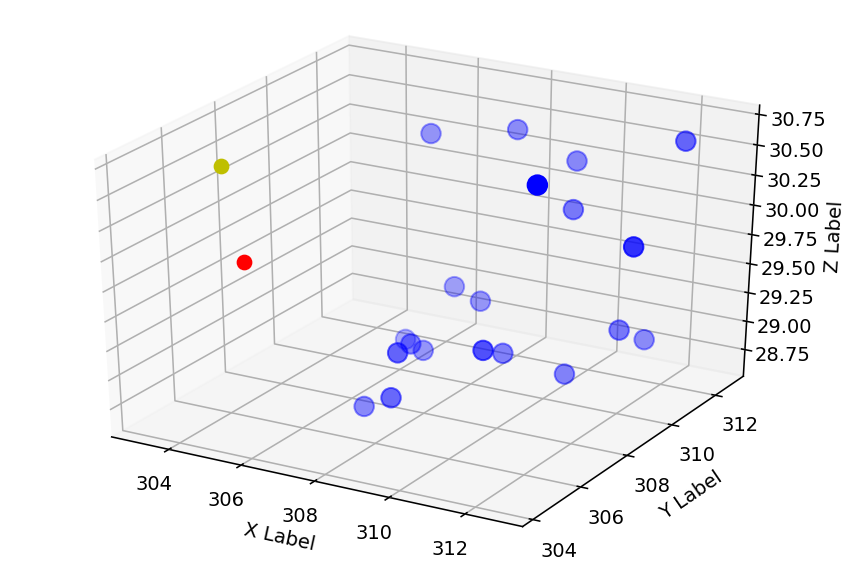

In [84]:
coord_3D = tranigulation(lab_M1, lab_M2, matches)
res1, res2 = residual(lab_M1, lab_M2, coord_3D, matches)
# print(res1, res2)
plot_3d(lab_center1, lab_center2, coord_3D)

<IPython.core.display.Javascript object>


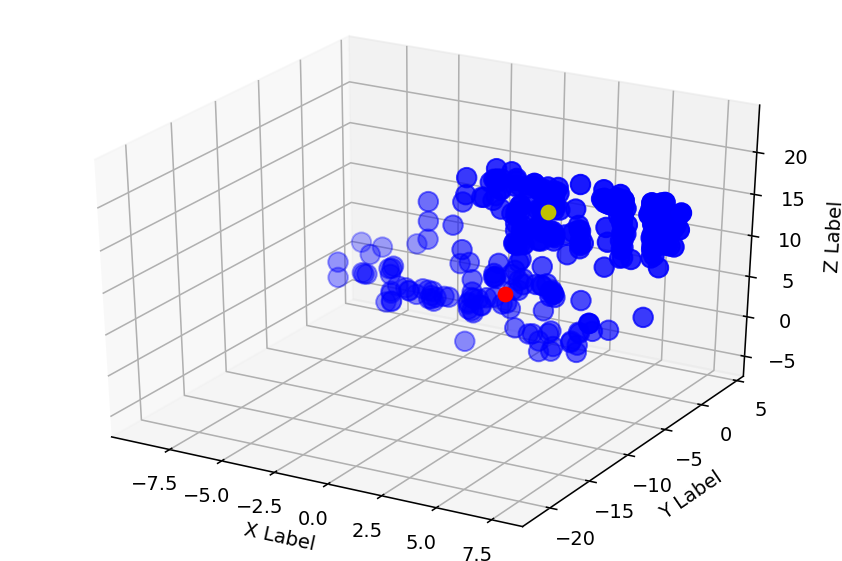

In [81]:
# Library pair
library_mat1 = np.loadtxt('MP3_part2_data/library1_camera.txt')
library_mat2 = np.loadtxt('MP3_part2_data/library2_camera.txt')
matches = np.loadtxt('MP3_part2_data/library_matches.txt')
coord_3D = tranigulation(library_mat1, library_mat2, matches)
res1, res2 = residual(library_mat1, library_mat2, coord_3D, matches)
# print(res1, res2)
library_center1 = camera_center(library_mat1)
library_center2 = camera_center(library_mat2)
plot_3d(library_center1, library_center2, coord_3D)